<a href="https://colab.research.google.com/github/rajaonsonella/csc2541_lab1/blob/main/lab1_post_module.ipynb?force_refresh=true" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSC2541 - Lab 1: Deep Learning for structure-based drug design (SBDD)

Structure-based drug design (SBDD) aims at designing small-molecule ligands that bind with high affinity and specificity to pre-determined protein targets which have been identified as having therapeutic potential. Specifically, this approach focuses on leveraging the 3D structure of the protein target to rationally design a ligand.

In this lab, we aim at giving you an introduction to SBDD and the latest deep learning models used in the field. The lab is structured into three parts

### Table of Content

1.   Pre-module: Introduction to the Protein Data Bank (PDB) (~30 mins)
2.   Module: Exploring how ML does at Ligand pose prediction (~50 mins)
3.   Post-module (assignment): Evaluating a state of the art ML model (Boltz2) on various protein ligand complex pose prediction (~60 mins)

# Colab Set Up

In [33]:
!pip install boltz[cuda] -U

  Using cached scipy-1.13.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
Using cached scipy-1.13.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (38.2 MB)
  Attempting uninstall: scipy
    Found existing installation: scipy 1.12.0
    Uninstalling scipy-1.12.0:
      Successfully uninstalled scipy-1.12.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jax 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
pytensor 2.35.1 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
shap 0.50.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.
tsfresh 0.21.1 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.
jaxlib 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.


In [34]:
!pip install -q py3Dmol

In [45]:
!pip install -U ProDy scipy==1.12

  Using cached scipy-1.12.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
Using cached scipy-1.12.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (37.8 MB)
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
boltz 2.2.1 requires scipy==1.13.1, but you have scipy 1.12.0 which is incompatible.
jax 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
jax 0.7.2 requires scipy>=1.13, but you have scipy 1.12.0 which is incompatible.
pytensor 2.35.1 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
shap 0.50.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.
tsfresh 0.21.1 requires scipy>=1.14.0; python_version >= "3.10"

# Post-Module: Assessing co-folding methods capabilities on a case study

In the main module, we have seen that RMSD alone is not necessarily a good indicator of how well our models can predict a good ligand pose. For that reason, the community came up with simple packages that allow to check if other characteristics such as chemical validity are preserved.

In the post-module, we would like to introduce the state of the art models in structure-based drug design so called "co-folding" models and evaluate their prediction. Before jumping into the practice, let's first review what these models are.

### Co-folding models

Co-folding -- originally developed as part of the DragonFold project at Charm Therapeutics -- builds on the protein structure prediction concepts pioneered by the team at DeepMind working on AlphaFold.

While early methods like AlphaFold2 and RoseTTAFold could “only” predict protein structures, these newer approaches can not only determine protein structures *but also* generate the structures of bound ligands.

Co-folding methods use a training set of structures from the PDB to learn the relationship between a protein structure and a corresponding bound ligand. The model learned from the training set is then used to generate the structures of new complexes.

The field is very excited about these methods as target-ligand co-folding methods may be able to surpass classical methods like docking and even replace physics-based free energy perturbation approaches, which demand computationally expensive molecular dynamics simulations and force field optimizations.


Regarding the PoseBusters Benchmark we have seen in the previous module, models like AlphaFold3 have recently achieved very good performance on it

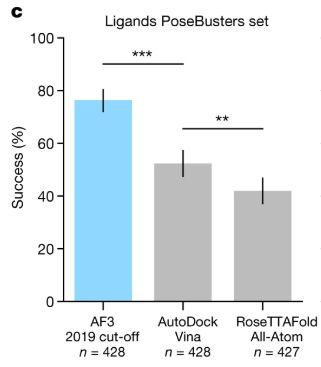

In this post-module, we are going to have a look at Boltz-2, the latest open-source co-folding model

### Logistics

For this lab, we are going to split into 2 groups


### Group 1:

> Ligand:
>
> * Name: 6IC
>
> * SMILES: FC1CC2(CCCN2C1)COc1nc2c(F)c(ncc2c(n1)N1CC2CCC(N2)C1)c1cc(O)cc2ccc(F)c(C#C)c21
>
> Protein:
> * PDB ID: 7XKJ

### Group 2:

> Ligand:
>
> * Name: YHC
>
> * SMILES: CCC1=C(N2CCN(CC2)C(=O)c3ncnc(C)c3O)C(=O)n4nc(nc4N1CC(=O)Nc5ccc(cc5Cl)C(F)(F)F)C6=CCOCC6
>
> Protein:
> * PDB ID: 8PFO

### Step 1: prepare the Boltz2 input

Given your group, create a file according to the instructions found [here](https://github.com/jwohlwend/boltz/blob/main/docs/prediction.md)

Upload this file to colab and name it ```boltz_input.yaml```

In [3]:
#TODO: Create the YAML file. To help you, have a look at the information on RCSB-PDB

### Step 2: Run Boltz2

In [37]:
#@title Run prediction using Boltz-2
#@markdown YAML filename
yaml_filename = '7xkj_input' #@param {type:"string"}
#@markdown Output format
output_format = 'mmcif' #@param ["pdb", "mmcif"]
#@markdown Number of dataloader workers
num_workers = 0 #@param {type:"slider", min:0, max:5, step:1}
#@markdown Lower the step scale to increase the diversity of result. (default: 1.638)
step_scale = 1.638 #@param {type:"slider", min:1, max:2, step:0.001}
#@markdown Number of diffusion samples to be generated. (default: 1, AlphaFold3: 5)
diffusion_samples = 1 #@param {type:"slider", min:1, max:10, step:1}
#@markdown Number of recycling steps for the prediction. (default: 3, AlphaFold3: 10)
recycling_steps = 3 #@param {type:"slider", min:1, max:25, step:1}
#@markdown Number of sampling steps for structure prediction. (default: 200)
sampling_steps = 50 #@param {type:"slider", min:50, max:400, step:50}
#@markdown Maximum number of MSA sequences to be used
max_msa_seqs = 8192 #@param [32, 64, 128, 256, 512, 1024, 2048, 4096, 8192]
#@markdown Subsample MSA?
subsample_msa = False #@param {type:"boolean"}
#@markdown Number of subsampled MSA
num_subsampled_msa = 1024 #@param [4, 8, 16, 32, 64, 128, 256, 512, 1024]
#@markdown MSA pairing strategy
msa_pairing_strategy = 'greedy' #@param ['greedy', 'complete']
#@markdown Use GPU
device = 'gpu' #@param ['gpu', 'cpu']

commandline = f'{yaml_filename}.yaml --num_workers {num_workers} --step_scale {step_scale} --recycling_steps {recycling_steps} --sampling_steps {sampling_steps}'
commandline += f' --diffusion_samples {diffusion_samples} --max_msa_seqs {max_msa_seqs} --msa_pairing_strategy {msa_pairing_strategy} --use_msa_server'
if subsample_msa:
    commandline += f' --num_subsampled_msa {num_subsampled_msa}'
if device == "gpu":
    commandline += ' --no_kernels --accelerator gpu'
else:
    commandline += ' --accelerator cpu'

!boltz predict {commandline} --out_dir /content/boltz_output

/usr/local/lib/python3.12/dist-packages/torch/__init__.py:1617: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  _C._set_float32_matmul_precision(precision)
MSA server enabled: https://api.colabfold.com
MSA server authentication: no credentials provided
Checking input data.
All inputs are already processed.
Processing 0 inputs with 0 threads.
0it [00:00, ?it/s]
Found some existing predictions (1), skipping and running only the missing ones, if any. If you wish to override these existing predictions, please

### Step 4: Analyze the prediction results

In [40]:
import py3Dmol
import requests
from IPython.display import display
from pathlib import Path

def view_cif(cif_path, width=800, height=600):
    import py3Dmol

    view = py3Dmol.view(width=width, height=height)
    with open(cif_path) as f:
        view.addModel(f.read(), "cif")

    view.setBackgroundColor("white")

    # Cartoon for protein (CIF-safe)
    view.setStyle({}, {"cartoon": {"color": "spectrum"}})

    # Sticks for non-polymer atoms (ligands)
    view.addStyle(
        {"hetflag": True},
        {"stick": {"radius": 0.25}}
    )

    # view.addStyle(
    #     {"hetflag": True, "bond": 0},  # atoms with no bonds are usually ions
    #     {"sphere": {"radius": 0.5, "color": "green"}}
    # )

    view.zoomTo()
    return view

def compare_cifs(
    cif_a,
    cif_b,
    width=900,
    height=650,
):
    import py3Dmol

    view = py3Dmol.view(width=width, height=height)
    view.setBackgroundColor("white")

    # --- Load first CIF (model 0) ---
    with open(cif_a) as f:
        view.addModel(f.read(), "cif")

    # --- Load second CIF (model 1) ---
    with open(cif_b) as f:
        view.addModel(f.read(), "cif")

    # ===== Protein cartoons =====
    view.setStyle(
        {"model": 0},
        {"cartoon": {"color": "blue"}}
    )

    view.setStyle(
        {"model": 1},
        {"cartoon": {"color": "orange", "opacity": 0.6}}
    )

    # ===== Ligands / hetero atoms =====
    view.addStyle(
        {"model": 0, "hetflag": True},
        {"stick": {"radius": 0.25, "color": "blue"}}
    )

    view.addStyle(
        {"model": 1, "hetflag": True},
        {"stick": {"radius": 0.25, "color": "orange"}}
    )

    view.zoomTo()
    return view

# Download a PDB file
def download_pdb_file(pdb_id: str) -> str:
    # url or pdb_id
    if pdb_id.startswith('http'):
        url = pdb_id
        filename = url.split('/')[-1]
    elif pdb_id.endswith(".pdb"):
        return pdb_id
    else:
        if pdb_id.startswith("AF"):
            url = f"https://alphafold.ebi.ac.uk/files/{pdb_id}-model_v3.pdb"
        else:
            url = f"http://files.rcsb.org/view/{pdb_id}.pdb"
        filename = f'{pdb_id}.pdb'

    pdb_req = requests.get(url)
    pdb_req.raise_for_status()
    open(filename, 'w').write(pdb_req.text)
    return filename

def download_cif_file(cif_id: str) -> str:
    """
    Download a structure as CIF / mmCIF.

    Accepts:
    - URL
    - local .cif file
    - RCSB PDB ID (e.g. 7XKJ)
    - AlphaFold ID (AF-XXXX)
    """
    # URL provided
    if cif_id.startswith("http"):
        url = cif_id
        filename = Path(url).name

    # Local CIF
    elif cif_id.endswith(".cif"):
        return cif_id

    # AlphaFold model
    elif cif_id.startswith("AF"):
        url = f"https://alphafold.ebi.ac.uk/files/{cif_id}-model_v3.cif"
        filename = f"{cif_id}.cif"

    # RCSB PDB entry → mmCIF
    else:
        pdb_id = cif_id.upper()
        url = f"https://files.rcsb.org/download/{pdb_id}.cif"
        filename = f"{pdb_id}.cif"

    resp = requests.get(url)
    resp.raise_for_status()

    with open(filename, "w") as f:
        f.write(resp.text)

    return filename

In [54]:
from prody import parseCIF, writeMMCIF, calcTransformation, matchAlign
import numpy as np

def align_structures_prody(ref_path, mob_path, out_path="aligned_mobile.pdb"):
    """
    Align mobile structure onto reference using backbone atoms (N, CA, C).
    Returns path to aligned mobile structure.
    """

    # Load structures
    ref = parseCIF(ref_path)
    mob = parseCIF(mob_path)

    # Select CA atoms only
    ref_ca = ref.select("protein and name CA")
    mob_ca = mob.select("protein and name CA")

    # Take the minimum number of atoms for alignment (like PyMOL)
    n_atoms = min(len(ref_ca), len(mob_ca))
    ref_ca = ref_ca[:n_atoms]
    mob_ca = mob_ca[:n_atoms]

    # Compute and apply 3D transformation
    trans = calcTransformation(mob_ca, ref_ca)
    trans.apply(mob)

    # Save aligned mobile structure
    writeMMCIF("aligned_mobile.cif", mob)

    # # Load reference and mobile structures
    # ref = parsePDB(ref_path)
    # mob = parsePDB(mob_path)

    # # Select backbone atoms (N, CA, C) for alignment
    # ref_bb = ref.select('protein and backbone and not hetero')
    # mob_bb = mob.select('protein and backbone and not hetero')


    # if ref_bb is None or mob_bb is None:
    #     raise ValueError("No backbone atoms found in one of the structures.")

    # results = matchAlign(mob_bb, ref_bb)  # no chain filter; handles all chains

    # print(results)


    # writePDB("aligned_mobile.pdb", mob)

    # # Save aligned structure
    # writePDB(out_path, mob)

    # return out_path


In [42]:
cif_file = f"/content/boltz_output/boltz_results_{yaml_filename}/predictions/{yaml_filename}/{yaml_filename}_model_0.cif"
view = view_cif(cif_file)
display(view)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [43]:
# @markdown > Enter the PDB ID here to source the starting structure of receptor. This PDB file will be pulled from RCSB PDB server.
# Download CIF file
pdb_code = "7XKJ" #@param {type:"string"}
download_cif_file(pdb_code)

'7XKJ.cif'

In [58]:
aligned_pdb = align_structures_prody(
    ref_path=f"/content/{pdb_code}.cif",
    mob_path=f"/content/boltz_output/boltz_results_{yaml_filename}/predictions/{yaml_filename}/{yaml_filename}_model_0.cif",
    out_path="boltz_prediction_aligned.pdb"
)

# Visualize aligned structure in py3Dmol
view = compare_cifs(
    "/content/aligned_mobile.cif",
    "7XKJ.cif",
)
display(view)


@> 1406 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:1406 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 1573 atoms and 1 coordinate set(s) were parsed in 0.03s.
DEBUG:.prody:1573 atoms and 1 coordinate set(s) were parsed in 0.03s.


3Dmol.js failed to load for some reason. Please check your browser console for error messages.